In [19]:
import numpy as np  
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
import os
from astropy.wcs import WCS
from photutils.aperture import CircularAperture, CircularAnnulus
from photutils.aperture import aperture_photometry
from photutils.aperture import ApertureStats
import sep
from reproject import reproject_interp
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.stats import sigma_clip
import json
import warnings
from astropy.wcs import FITSFixedWarning
warnings.simplefilter('ignore', category=FITSFixedWarning)
import warnings
warnings.filterwarnings("ignore",
                        message="Input data contains invalid values",
                        category=UserWarning,
                        module="astropy")
import warnings
warnings.filterwarnings("ignore", message="invalid value encountered in sqrt")

import warnings
warnings.filterwarnings("ignore", message="invalid value encountered in Log10")


In [20]:
GAIAspectrum = fits.open('GAIA3_509862066010920960.fits')

def Factor(filtro):

    file_name = f"{filtro}_trasmission.txt"

    r_trasm = Table.read(file_name, format='ascii.basic')
    r_wave=r_trasm["Wavelength(A)"]
    r_value=r_trasm["Transmission(QE*Filter)"]

    r_trasm_new=np.interp(GAIAspectrum[1].data, r_wave, r_value)

    x=GAIAspectrum[1].data
    y_filter=r_trasm_new
    y_spectrum=np.array(GAIAspectrum[0].data)

    Num = np.trapz(y_spectrum * y_filter, x)
    Den= np.trapz(y_filter, x)
    return Num/Den           # Factor for the flux

In [21]:
def bias():
    Grid=[]
    path=os.getcwd()+'/bias'
    for file in os.listdir(path):
        fitsfile=fits.open(path+'/'+file)
        dati = fitsfile[0].data
        Grid.append(dati)
    return np.mean(Grid, axis=0)

def flat(filtro):   
    pathf=os.getcwd()+f"/{filtro}FLAT"
    
    Grid=[]
    for file in os.listdir(pathf):
        fitsfile=fits.open(pathf+'/'+file)
        dati = fitsfile[0].data
        Grid.append(dati)
    master=np.median(Grid, axis=0)-bias()
    
    return master/np.median(master)

def dark_current(exptime):

    pathd=os.getcwd()+'/DARK'+f'{exptime}'
    Grid=[]
    for file in os.listdir(pathd):
        fitsfile=fits.open(pathd+'/'+file)
        dati = fitsfile[0].data
        Grid.append(dati)

    master=np.median(Grid, axis=0)-bias()
    return master


def background(data2, pixpos):

    pixpos_x=int(pixpos[0])
    pixpos_y=int(pixpos[1])

    data_cut = data2[pixpos_y-50:pixpos_y+50,pixpos_x-50:pixpos_x+50]
    position = [50, 50]     #in the center 

    ap = CircularAperture(position, r=15)
    photo_inside = aperture_photometry(data_cut,ap)
    final_flux = photo_inside[0][3:]

    annulus_ap=CircularAnnulus(position, r_in=20, r_out=30)
    aperstats= ApertureStats(data_cut, annulus_ap)
    bkg_mean=aperstats.mean

    aperture_area=ap.area
    total_bkg=bkg_mean*aperture_area
    
    return final_flux - total_bkg

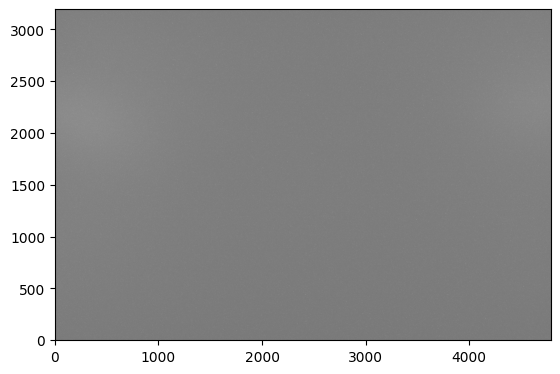

In [22]:
dark_current_300=dark_current(300)
meanc=np.mean(dark_current_300)
stdc=np.std(dark_current_300)
plt.imshow(dark_current_300, cmap='gray', vmin=meanc-2*stdc, vmax=meanc+2*stdc,origin='lower')

In [23]:
# M103 coordinates
c = SkyCoord('01:33:12 +60:42:00', unit=(u.hourangle, u.deg))

ref_wcs =  WCS(naxis=2)

ref_wcs.wcs.crval =[c.ra.degree, c.dec.degree]
ref_wcs.wcs.crpix =[4000/2.0, 4000/2.0]  
ref_wcs.wcs.ctype =["RA---TAN", "DEC--TAN"] 
ref_wcs.wcs.cunit=["deg", "deg"]

#trasformation of 0.55 arcsec/pixel
dim_degrees= (0.55/3600.0)

ref_wcs.wcs.cd= np.array([[-dim_degrees, 0.0], [0.0, dim_degrees]])

In [24]:
masterbias=bias()

In [25]:
def DataProcess(filtro, exptime):

    Path = os.path.join(os.getcwd(), 'DATA'+f'{exptime}', filtro)
    mastercurrent=0
    
    if exptime!=5:
         mastercurrent=dark_current(exptime)

    masterflat=flat(filtro)

    all_images=[]
    Calibrations=[]

    for file in os.listdir(Path):       #for all the file in the filter of a given day
        if not file.lower().endswith('.fits'):
            continue

        Fitsfile=fits.open(Path+'/'+file)

        #read the data 
        Data = Fitsfile[0].data

        #coordinates of the image
        wcs = WCS(Fitsfile[0].header)
        pixpos = wcs.wcs_world2pix(23.38804096055661,60.63702187961969, 1)         #coordinates of the star for calibration

        data1 = (Data-masterbias-mastercurrent)/masterflat
        
        data2=data1*0.25/exptime                                    # to have the flux in e-/s     
        
        Calibration_costant=Factor(filtro)/background(data2, pixpos) #calibartion costant and 10**16 preventing numerical error 
        Calibrations.append(Calibration_costant)

        data3=data2*Calibration_costant*10**16                 #calibartion costant and 10**16 preventing numerical error 
        data=data3-np.median(data3)
        std=np.std(data3)
        objects, map = sep.extract(data, 1.5, err=std, segmentation_map=True)              #return an image 


        bkg = sep.Background(data, mask=map, bw=64, bh=64, fw=12, fh=12)
        Final=data3-bkg

        #reproject the image 
        new_repr= reproject_interp((Final, wcs), ref_wcs, shape_out=(4000,4000))
        all_images.append(new_repr[0])
    
    return np.median(all_images, axis=0), np.median(Calibrations, axis=0)       #choose the correct axis 

In [26]:
def flux_and_errors(Result, pixpos, Cal, exptime, clipped):

    data_cut = Result[int(pixpos[1]-50):int(pixpos[1]+50),int(pixpos[0]-50):int(pixpos[0]+50)]
    position = [50, 50]     #in the center 

    ap = CircularAperture(position, r=15)
    photo_inside = aperture_photometry(data_cut,ap)
    aperture_sum=photo_inside[0][3]

    annulus_aperture = CircularAnnulus(position, r_in=20, r_out=30)
    aperstats = ApertureStats(data_cut, annulus_aperture)

    bkg_mean = aperstats.mean   # mean background for each pixel

    # I compute the flux (I need to subtract the background!)
    aperture_area = ap.area_overlap(data_cut) # aperture area with r=15
    total_bkg = bkg_mean * np.array(aperture_area)
    clipped_bkg=sigma_clip(total_bkg)
    phot_bkgsub =  np.array(aperture_sum) - clipped_bkg                 # I subtract the background
   
    n_pixels=ap.area

    sigma_b=clipped*np.sqrt(n_pixels)
    sigma_f=np.sqrt((Cal*10**16/exptime*phot_bkgsub))         #10**16!!!
    E=np.sqrt(sigma_f**2 + sigma_b**2)
     
    return phot_bkgsub, E

In [27]:
Result_r300, Cal_r300 = DataProcess('R',300)

In [28]:
Result_g300, Cal_g300 = DataProcess('G',300)

In [ ]:
Result_i300, Cal_i300 = DataProcess('I',300)

In [ ]:
catalogue = Table.read('M103_membership_selected.fits')
pixpos=ref_wcs.wcs_world2pix(catalogue['RAdeg'], catalogue['DEdeg'],1)

In [ ]:
histo_r300=Result_r300.flatten()
backs_r300=sigma_clip(histo_r300, sigma=3, maxiters=5)
clipped_r300=np.std(backs_r300)

histo_g300=Result_g300.flatten()
backs_g300=sigma_clip(histo_g300, sigma=3, maxiters=5)
clipped_g300=np.std(backs_g300)

histo_i300=Result_i300.flatten()
backs_i300=sigma_clip(histo_i300, sigma=3, maxiters=5)
clipped_i300=np.std(backs_i300)

In [ ]:
Flux_star_r300 = []
Error_r300 = [] 
for i in range(0,len(catalogue)):
    fluxr, errorr=flux_and_errors(Result_r300, [pixpos[0][i], pixpos[1][i]], Cal_r300, 300, clipped_r300)
    Flux_star_r300.append(fluxr)
    Error_r300.append(errorr)

Flux_star_g300 = []
Error_g300 = [] 
for i in range(0,len(catalogue)):
    fluxg, errorg=flux_and_errors(Result_g300, [pixpos[0][i], pixpos[1][i]], Cal_g300, 300, clipped_g300)
    Flux_star_g300.append(fluxg)
    Error_g300.append(errorg)

Flux_star_i300 = []
Error_i300 = [] 
for i in range(0,len(catalogue)):
    fluxi, errori=flux_and_errors(Result_i300, [pixpos[0][i], pixpos[1][i]], Cal_i300, 300, clipped_i300)
    Flux_star_i300.append(fluxi)
    Error_i300.append(errori)

In [ ]:
lg=4500
li=8000
c=3*10**(18)
lr=6500

Flux_g300=np.array(Flux_star_g300)*10**(-16)*lg**2/c
Err_g300=np.array(Error_g300)*10**(-16)*lg**2/c
magnitude_g300=-2.5*np.log10(Flux_g300)-48.6
err_magn_g300=2.5*np.array(Err_g300.flatten()/Flux_g300/np.log(10))


Flux_r300=np.array(Flux_star_r300)*10**(-16)*lr**2/c
Err_r300=np.array(Error_r300)*10**(-16)*lr**2/c
magnitude_r300=np.array(-2.5*np.log10(Flux_r300)-48.6)
err_magn_r300=2.5*Err_r300.flatten()/Flux_r300/np.log(10)


Flux_i300=np.array(Flux_star_i300)*10**(-16)*lr**2/c
Err_i300=np.array(Error_i300)*10**(-16)*lr**2/c
magnitude_i300=np.array(-2.5*np.log10(Flux_i300)-48.6)
err_magn_i300=2.5*Err_i300.flatten()/Flux_i300/np.log(10)

In [ ]:
isochrone = Table.read('isochrone_grid_parsec.dat', format='ascii')

mask_metal=isochrone['MH']==0     #solar metallicity 
mask_age=isochrone['logAge']==6 

rmag=isochrone['rmag']
gmag=isochrone['gmag']
imag=isochrone['imag']

maskr=magnitude_r300<17
m_r300=magnitude_r300[maskr]
err_r300=err_magn_r300[maskr]
m_g300=magnitude_g300[maskr]
err_g300=err_magn_g300[maskr]


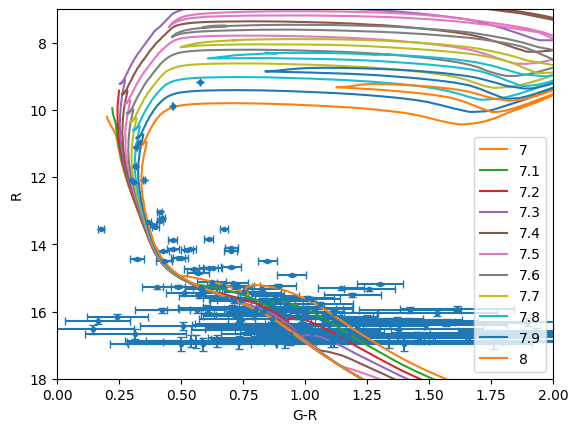

In [ ]:
plt.errorbar(m_g300 - m_r300, m_r300, xerr=  np.sqrt(err_g300**2 + err_r300**2), yerr=err_r300, capsize=3, marker='.', linestyle='')
plt.xlabel('G-R')
plt.ylabel('R')
plt.ylim(18, 7)
plt.xlim(0, 2)


ages=[7,7.1,7.2,7.3,7.4,7.5,7.6,7.7,7.8,7.9,8]
for a in ages:
    mask_age=isochrone['logAge']==a 
    r = rmag[(mask_metal&mask_age)]
    g = gmag[(mask_metal&mask_age)]
    color = g-r
    plt.plot(color+0.71, r+13, label=a)

plt.legend();

In [ ]:
Result_r5, Cal_r5 = DataProcess('R',5)
Result_i5, Cal_i5= DataProcess('I',5)
Result_g5, Cal_g5 = DataProcess('G',5)

In [ ]:
histo_r5=Result_r5.flatten()
backs_r5=sigma_clip(histo_r5, sigma=3, maxiters=5)
clipped_r5=np.std(backs_r5)

histo_g5=Result_g5.flatten()
backs_g5=sigma_clip(histo_g5, sigma=3, maxiters=5)
clipped_g5=np.std(backs_g5)

histo_i5=Result_i5.flatten()
backs_i5=sigma_clip(histo_i5, sigma=3, maxiters=5)
clipped_i5=np.std(backs_i5)

In [ ]:
Flux_star_r5 = []
Error_r5 = [] 
for i in range(0,len(catalogue)):
    fluxr5, errorr5=flux_and_errors(Result_r5, [pixpos[0][i], pixpos[1][i]], Cal_r5, 5, clipped_r5)
    Flux_star_r5.append(fluxr5)
    Error_r5.append(errorr5)

Flux_star_g5 = []
Error_g5 = [] 
for i in range(0,len(catalogue)):
    fluxg5, errorg5=flux_and_errors(Result_g5, [pixpos[0][i], pixpos[1][i]], Cal_g5, 5, clipped_g5)
    Flux_star_g5.append(fluxg5)
    Error_g5.append(errorg5)

Flux_star_i5 = []
Error_i5 = [] 
for i in range(0,len(catalogue)):
    fluxi5, errori5=flux_and_errors(Result_i5, [pixpos[0][i], pixpos[1][i]], Cal_i5, 5, clipped_i5)
    Flux_star_i5.append(fluxi5)
    Error_i5.append(errori5)

In [ ]:
lg=4500
li=8000
c=3*10**(18)
lr=6500

Flux_g5=np.array(Flux_star_g5)*10**(-16)*lg**2/c
Err_g5=np.array(Error_g5)*10**(-16)*lg**2/c
magnitude_g5=-2.5*np.log10(Flux_g5)-48.6
err_magn_g5=2.5*np.array(Err_g5.flatten()/Flux_g5/np.log(10))


Flux_r5=np.array(Flux_star_r5)*10**(-16)*lr**2/c
Err_r5=np.array(Error_r5)*10**(-16)*lr**2/c
magnitude_r5=np.array(-2.5*np.log10(Flux_r5)-48.6)
err_magn_r5=2.5*Err_r5.flatten()/Flux_r5/np.log(10)


Flux_i5=np.array(Flux_star_i5)*10**(-16)*lr**2/c
Err_i5=np.array(Error_i5)*10**(-16)*lr**2/c
magnitude_i5=np.array(-2.5*np.log10(Flux_i5)-48.6)
err_magn_i5=2.5*Err_i5.flatten()/Flux_i5/np.log(10)

In [ ]:
maskr_5=magnitude_r5<11.5
m_r5=magnitude_r5[maskr_5]
err_r5=err_magn_r5[maskr_5]
m_g5=magnitude_g5[maskr_5]
err_g5=err_magn_g5[maskr_5]

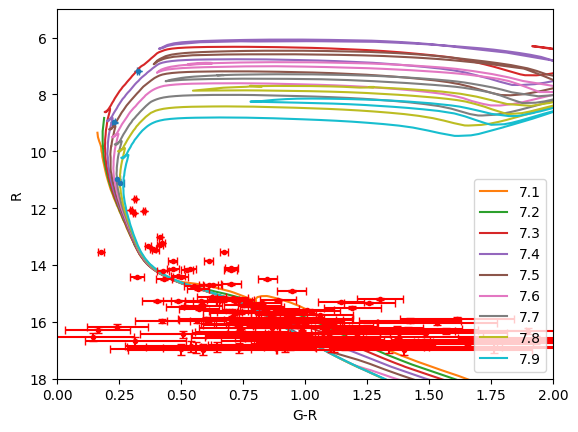

In [ ]:
plt.errorbar(m_g5 - m_r5, m_r5, xerr=  np.sqrt(err_g5**2 + err_r5**2), yerr=err_r5, capsize=3, marker='.', linestyle='')
plt.xlabel('G-R')
plt.ylabel('R')
plt.ylim(18, 5)
plt.xlim(0, 2)


ages=[7.1,7.2,7.3,7.4,7.5,7.6,7.7,7.8,7.9]
for a in ages:
    mask_age=isochrone['logAge']==a 
    r = rmag[(mask_metal&mask_age)]
    g = gmag[(mask_metal&mask_age)]
    color = g-r
    plt.plot(color+0.65, r+12.4, label=a)

plt.errorbar(m_g300[m_r300>11.5] - m_r300[m_r300>11.5], m_r300[m_r300>11.5], xerr=  np.sqrt(err_g300[m_r300>11.5]**2 + err_r300[m_r300>11.5]**2), yerr=err_r300[m_r300>11.5], capsize=3, marker='.', linestyle='', color='red')
plt.legend();

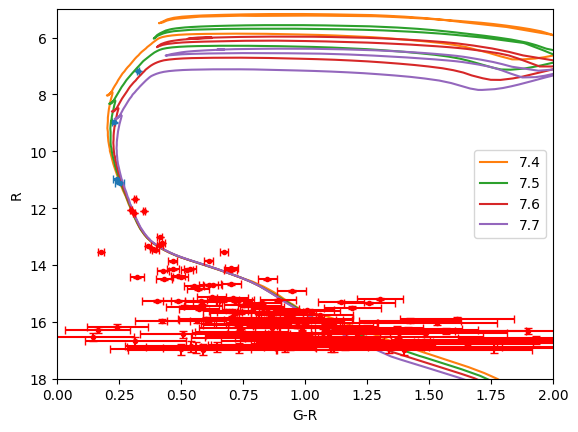

In [ ]:
plt.errorbar(m_g5 - m_r5, m_r5, xerr=  np.sqrt(err_g5**2 + err_r5**2), yerr=err_r5, capsize=3, marker='.', linestyle='')
plt.xlabel('G-R')
plt.ylabel('R')
plt.ylim(18, 5)
plt.xlim(0, 2)


ages=[7.4,7.5,7.6,7.7]
for a in ages:
    mask_age=isochrone['logAge']==a 
    r = rmag[(mask_metal&mask_age)]
    g = gmag[(mask_metal&mask_age)]
    color = g-r
    plt.plot(color+0.65, r+11.5, label=a)

plt.errorbar(m_g300[m_r300>11.5] - m_r300[m_r300>11.5], m_r300[m_r300>11.5], xerr=  np.sqrt(err_g300[m_r300>11.5]**2 + err_r300[m_r300>11.5]**2), yerr=err_r300[m_r300>11.5], capsize=3, marker='.', linestyle='', color='red')
plt.legend();